In [19]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import librosa
import os
import pandas as pd
import sounddevice as sd


In [2]:
CHANNELS = 1
SR = 48000 # Sample rate in Hz
FORMAT = pyaudio.paFloat32  # 16-bit audio format
AMPLIFICATION_FACTOR = 10**(47 / 20)  # Convert 47 dB to linear scale
CHUNK = 16384*4# 4096*4 # Number of frames per buffer

In [3]:
audio = pyaudio.PyAudio()
input_device_index = None
for i in range(audio.get_device_count()):
    device_info = audio.get_device_info_by_index(i)
    
    if (not input_device_index and "MAYA44USB" in device_info['name'] and "Ch12" in device_info['name'] and 
        device_info['maxInputChannels'] == 4):
        input_device_index = i
    # if (not output_device_index and "MAYA44USB" in device_info['name'] and "Ch12" in device_info['name'] and 
    #     device_info['maxOutputChannels'] == 4):
    #     output_device_index = i
audio = pyaudio.PyAudio()
stream = audio.open(
    format=FORMAT,      #? they used paInt32 in the paper
    channels=CHANNELS,
    rate=SR,
    # output=True,
    input=True,
    input_device_index=input_device_index,
    frames_per_buffer=CHUNK
    # output_device_index=output_device_index
)
data = np.frombuffer(stream.read(CHUNK, exception_on_overflow=True), dtype=np.float32)
stream.stop_stream()
stream.close()
audio.terminate()

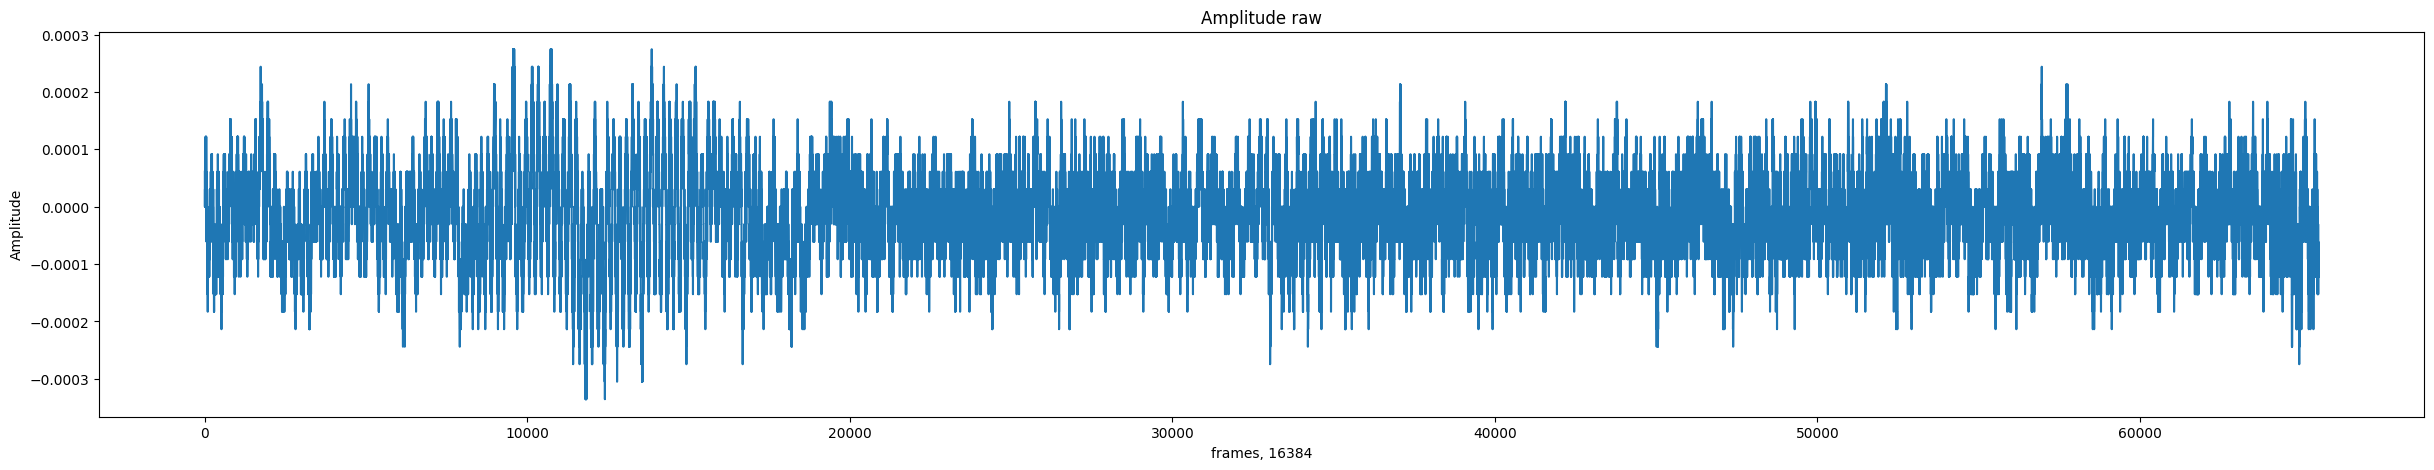

In [33]:
plt.figure(figsize=(30, 5))
plt.plot(data)
plt.title("Amplitude raw")
plt.xlabel("frames, 16384")
plt.ylabel("Amplitude")
plt.show()

In [34]:
# Normalize the data
data_norm = data / np.max(np.abs(data))

# Compute the FFT spectrum
data_spectrum = np.fft.rfft(data_norm)

# Extract amplitude (magnitude) and phase (angle)
data_amplitude = np.abs(data_spectrum)
data_phase = np.angle(data_spectrum)

# Compute frequency bins
data_frequency = np.fft.rfftfreq(len(data), 1/SR)

# Create a DataFrame with frequency, amplitude, and phase
data_series = pd.DataFrame({
    "Amplitude": data_amplitude,
    "Phase": data_phase
}, index=pd.Index(data_frequency, name="Frequency"))
data_series

,Amplitude,Phase
Frequency,,
0.000000,2919.818262,3.141593
0.732422,19.668196,1.377814
1.464844,93.014608,-2.862639
2.197266,190.244162,-2.577675
2.929688,143.024900,-2.447908
...,...,...
23997.070312,12.006740,-3.112319
23997.802734,6.286942,1.160850
23998.535156,7.462842,-1.301574


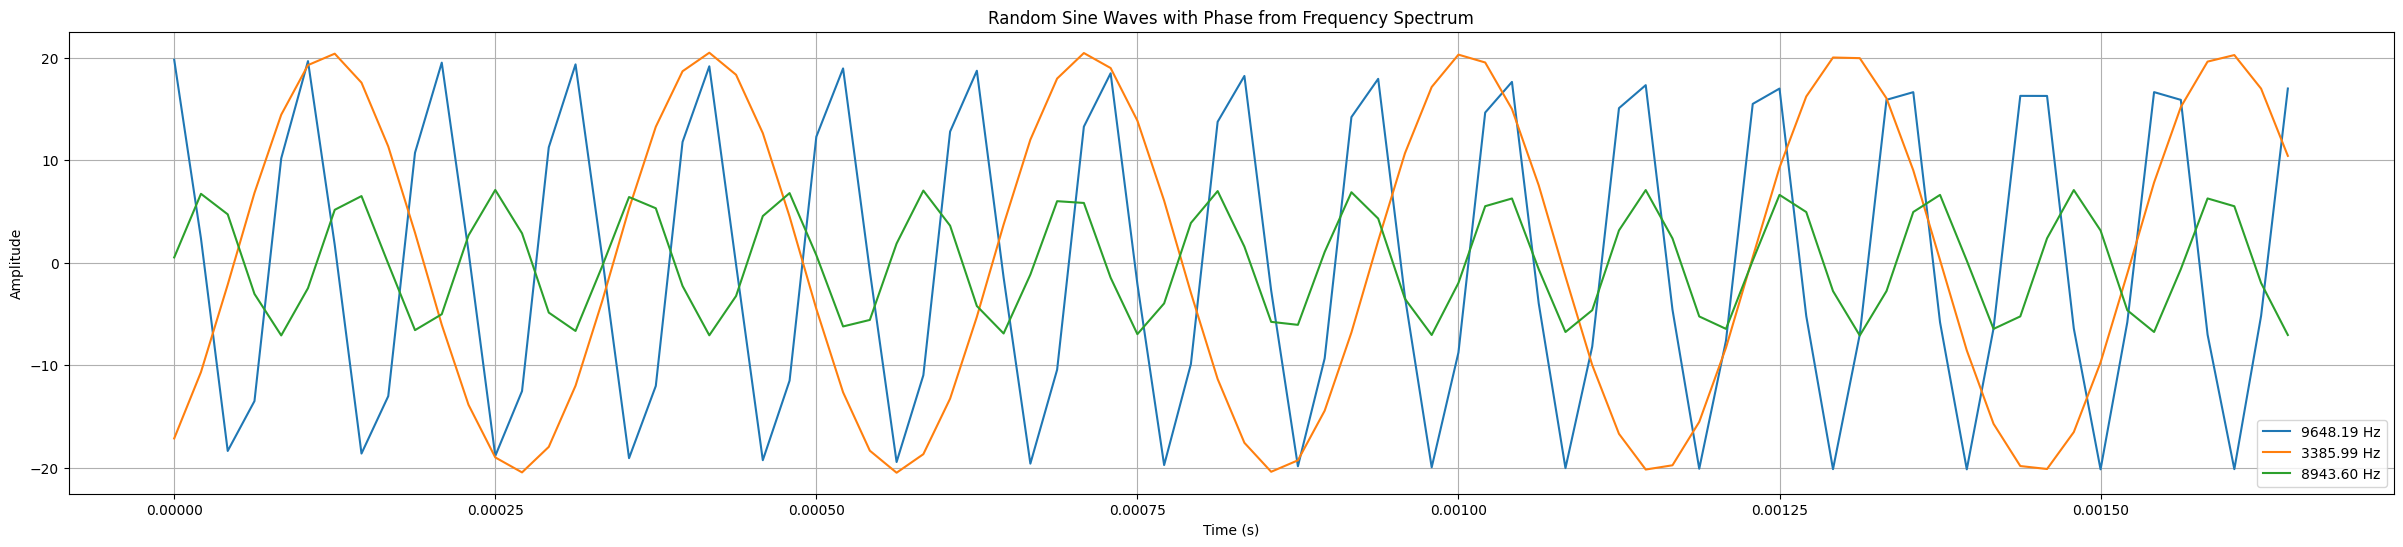

In [37]:
# Randomly select 3 rows from the data_df (frequency, amplitude, and phase)
random_samples = data_series.sample(3)

# Set up time range for plotting (e.g., 1 second at SR = 48000 Hz)
SR = 48000  # Sampling rate
duration = 1  # seconds
t = np.linspace(0, duration, int(SR * duration), endpoint=False)

# Create and plot the sine waves
plt.figure(figsize=(30, 6))
for frequency, row in random_samples.iterrows():
    amplitude = row["Amplitude"]
    phase = row["Phase"]
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * t + phase)  # Apply phase shift
    plt.plot(t[:80], sine_wave[:80], label=f"{frequency:.2f} Hz")  # Plot first 100 points for clarity

# Add labels and legend
plt.title("Random Sine Waves with Phase from Frequency Spectrum")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

<Axes: title={'center': 'Frequency Spectrum'}, xlabel='Frequency (Hz)', ylabel='Amplitude'>

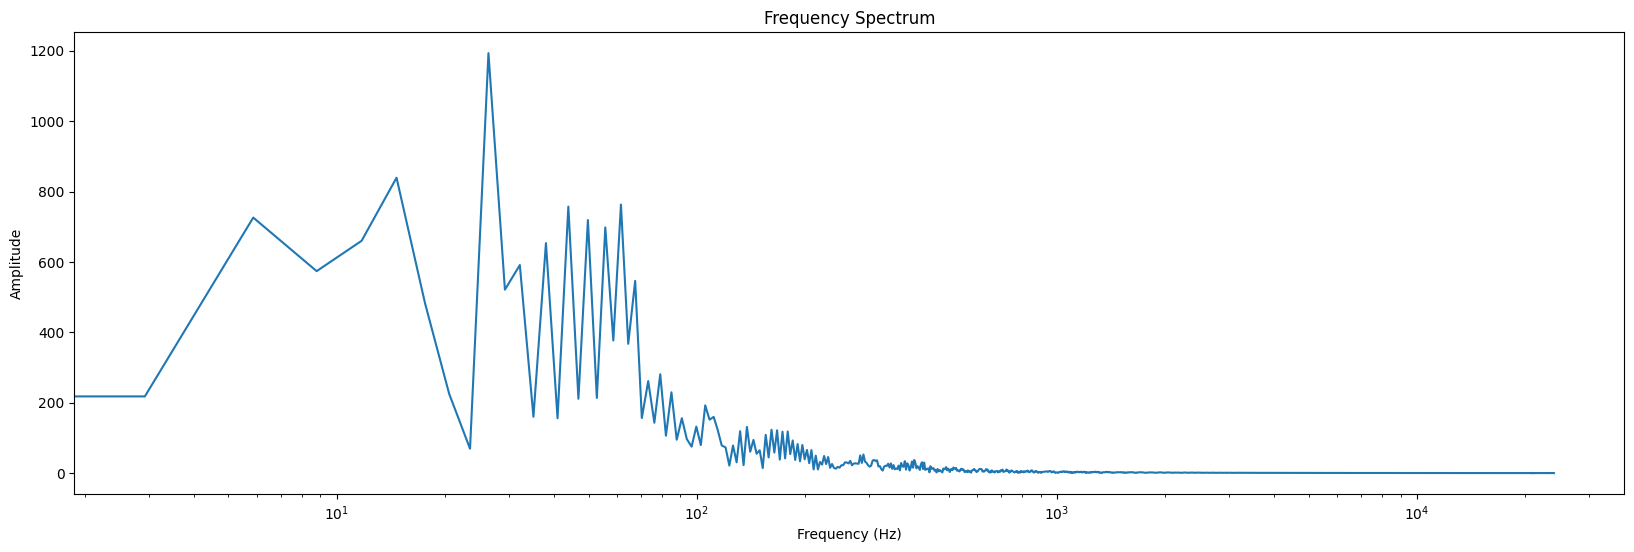

In [33]:
data_series.plot(title="Frequency Spectrum", xlabel="Frequency (Hz)", ylabel="Amplitude", logy=False, logx=True, figsize=(20, 6))

In [13]:
# # Function to update the plot
# def live_audio_visualization():
#     plt.ion()  # Enable interactive mode
#     fig, ax = plt.subplots(figsize=(10, 4))
#     x = np.arange(0, CHUNK)
#     line, = ax.plot(x, np.random.rand(CHUNK))
#     ax.set_ylim(-5000, 5000)
#     ax.set_xlim(0, CHUNK)
#     ax.set_title("Live Microphone Input")
#     ax.set_xlabel("Samples")
#     ax.set_ylabel("Amplitude")

#     try:
#         while True:
#             data = np.frombuffer(stream.read(CHUNK, exception_on_overflow=True), dtype=np.int16)# * AMPLIFICATION_FACTOR
#             line.set_ydata(data)
#             plt.pause(0.01)  # Pause to update the plot
#             clear_output(wait=True)
#             display(fig)
#     except KeyboardInterrupt:
#         print("Visualization Stopped.")
#     finally:
#         plt.close(fig)
#         stream.stop_stream()
#         stream.close()
#         audio.terminate()

# # Run Visualization
# live_audio_visualization()